In [1]:
import os
import numpy as np
from tqdm import tqdm as tqdm
import torchvision.transforms.functional as TF

import sys
CURRENT_DIR = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
sys.path.append(parent_dir)

from utils.helpers import crop_image
from models.change_vit import Trainer, Encoder, Decoder, DinoVisionTransformer, PatchEmbed, Block, MemEffAttention, Mlp, BasicBlock, FeatureInjector, BlockInjector, CrossAttention, MlpDecoder, ResNet
from models.efficientunet import CDUnet, UpSamplingBlock, ConvBlock
from models.siamconc import SiamUnet_conc
from models.siamdiff import SiamUnet_diff
from models.stackunet import Unet
from models.efficientunet_respath_attn import CDUnetResPath, Respath, BasicConv, GridAttentionBlock2D

from models.model import SupervisedModel, SemiSupervisedModel

from utils.preprocessing import Preprocessor

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess(img1):
    img1_norm = TF.normalize(TF.to_tensor(img1), mean=(0.485), std=(0.229))
    return img1_norm

def reconstruct_image(patches, patch_shape, patch_size):
    patch_grid_height, patch_grid_width = patch_shape
    img_height = patch_grid_height * patch_size
    img_width = patch_grid_width * patch_size
    channels = patches[0][0].shape[0]  # Assuming all patches have the same number of channels
    image = np.zeros((img_height, img_width, channels), dtype=patches[0].cpu().detach().numpy()[0].dtype)

    idx = 0
    for i in range(patch_grid_height):
        for j in range(patch_grid_width):
            image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = np.transpose(patches[idx].cpu().detach().numpy()[0], (1, 2, 0))
            idx += 1
    return image


def predict(model, circle_before, circle_after):
    before_sample = np.array(circle_before)
    after_sample = np.array(circle_after)

    before_patches = crop_image(before_sample)
    after_patches = crop_image(after_sample)

    model.eval()
    result_patches = []
    for before_patch, after_patch in zip(before_patches, after_patches):
        result = model(preprocess(before_patch)[None, ...], preprocess(after_patch)[None, ...])
        result_patches.append(result)

    reconstructed_image = reconstruct_image(result_patches, [4, 4], 500)
    return reconstructed_image


In [7]:
INTERVAL = 10  # interval (in seconds) of taking a snapshot
NUM_SNAPSHOTS = 5
video_before_path = f"{CURRENT_DIR}/../videos/1A.MP4"
video_after_path = f"{CURRENT_DIR}/../videos/c1A.MP4"


preprocessor = Preprocessor(f"{CURRENT_DIR}/../weights/circle_segmentation/circle_segmentation_30e_sched")
circle_pairs = preprocessor.extract_circles(video_before_path, video_after_path, num_pairs=NUM_SNAPSHOTS, interval=INTERVAL)
aligned_circles = preprocessor.align_circles(circle_pairs, angle_check=4) # decrease angle if alignment is not satisfactory
normalized_circles = preprocessor.normalize_to_start_pos(aligned_circles, interval=INTERVAL)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
weights_path = f"{CURRENT_DIR}/../weights/change_detection/changeViT.pth"
model = SupervisedModel(weights_path, input_size=[256, 256], output_size=[500, 500])

# NOTE: Uncomment desired model

# weights_path = f"{CURRENT_DIR}/../weights/change_detection/efficientunet.pth"
# model = SupervisedModel(weights_path, input_size=[512, 512], output_size=[500, 500])

# weights_path = f"{CURRENT_DIR}/../weights/change_detection/effrespath.pth"
# model = SupervisedModel(weights_path, input_size=[512, 512], output_size=[500, 500])

# weights_path = f"{CURRENT_DIR}/../weights/change_detection/effrespathattn.pth"
# model = SupervisedModel(weights_path, input_size=[512, 512], output_size=[500, 500])

# weights_path = f"{CURRENT_DIR}/../weights/change_detection/siamconc.pth"
# model = SupervisedModel(weights_path, input_size=[500, 500], output_size=[500, 500])

# weights_path = f"{CURRENT_DIR}/../weights/change_detection/siamdiff.pth"
# model = SupervisedModel(weights_path, input_size=[500, 500], output_size=[500, 500])

# weights_path = f"{CURRENT_DIR}/../weights/change_detection/stackunet.pth"
# model = SupervisedModel(weights_path, input_size=[500, 500], output_size=[500, 500])


# model = SemiSupervisedModel("pred_diff")
# model = SemiSupervisedModel("siamthresh")
# model = SemiSupervisedModel("siamthresh")

In [9]:
predictions = [predict(model, circle_pair[0], circle_pair[1]) for circle_pair in normalized_circles]
average_prediction = np.mean(predictions, axis=0)

Text(0.5, 1.0, 'Average prediction over multiple snapshots')

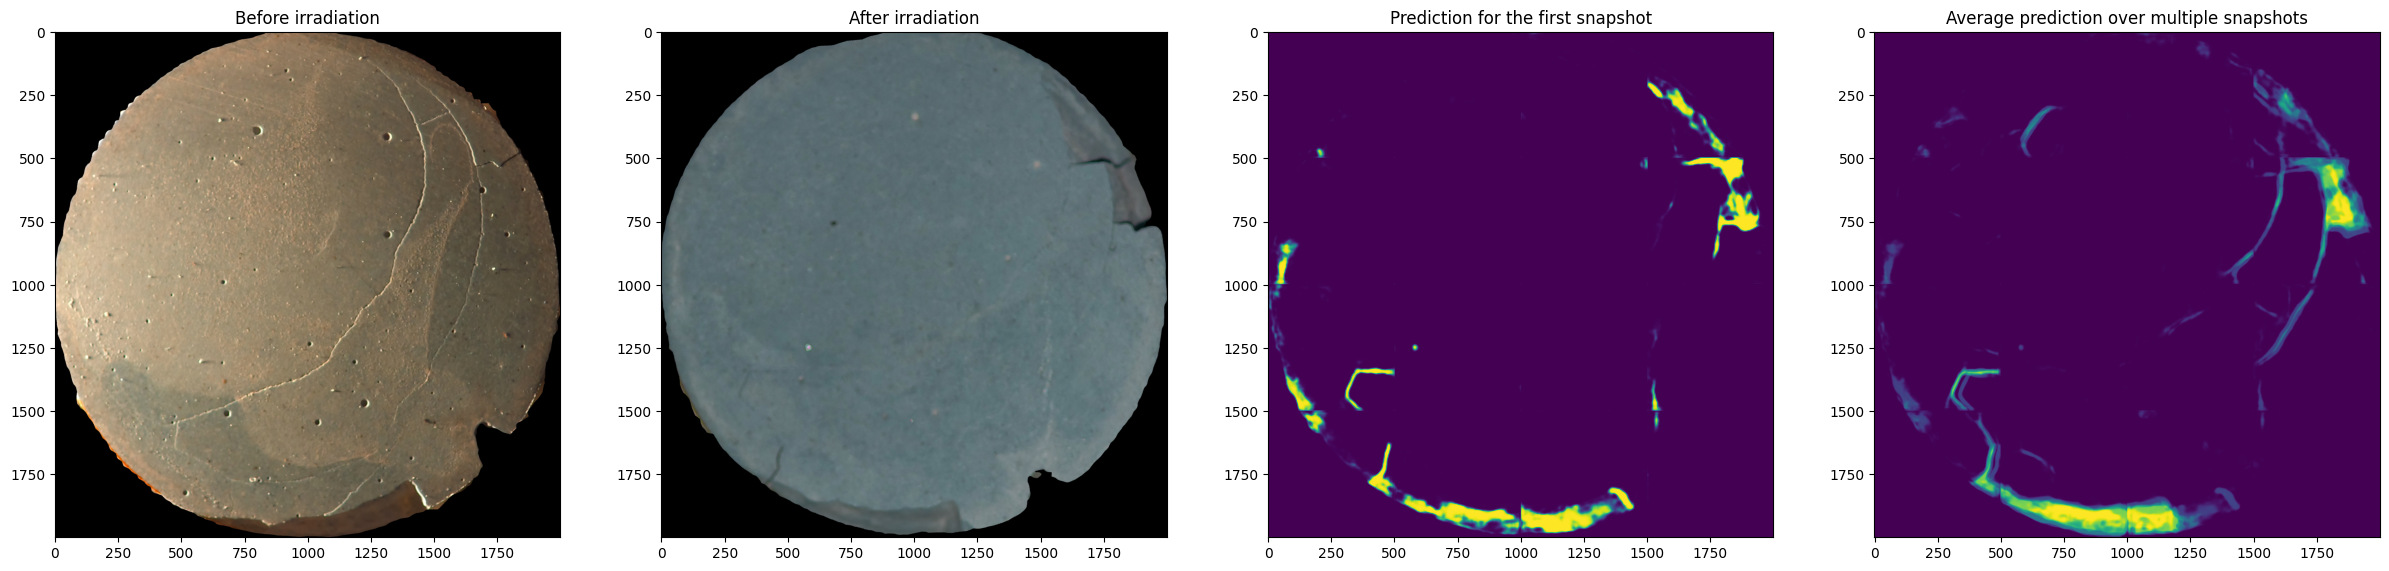

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 15))
fig.add_subplot(1, 4, 1)
plt.imshow(normalized_circles[0][0])
plt.title("Before irradiation")
fig.add_subplot(1, 4, 2)
plt.imshow(normalized_circles[0][1])
plt.title("After irradiation")
fig.add_subplot(1, 4, 3)
plt.imshow(predictions[0])
plt.title("Prediction for the first snapshot")
fig.add_subplot(1, 4, 4)
plt.imshow(average_prediction)
plt.title("Average prediction over multiple snapshots")